In [1]:
import os
import NN
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

## Train and Evaluate a PSN model

### Setup Parameters

In [2]:
ETF = 'DIA' # 'SPY', 'DIA', 'QQQ'
NNtype = 'PSN' # 'MLP', 'RNN', 'PSN'
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype] # SPYfeatures, DIAfeatures, QQQfeatures

### Load Dataframes

In [3]:
traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

### Initialize DataLoaders

In [4]:
features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'

trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

max_ = traindf.Return.max()
min_ = traindf.Return.min()

traindf = (traindf - min_) / (max_ - min_)
validdf = (validdf - min_) / (max_ - min_)
testdf = (testdf - min_) / (max_ - min_)

trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False, mu=trainmu, sigma=trainsigma)
validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False, mu=validmu, sigma=validsigma)
testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False, mu=testmu, sigma=testsigma)

### Instanciate Model

In [5]:
model = NN.Model(NNtype)
model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            200,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

PSN(
  (fc): Linear(in_features=7, out_features=6, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)


### Training

In [6]:
model.train(trainloader, validloader)

[00:00] Epoch 1/200 - Train Loss : 0.015058 / Val Loss : 0.005904
[00:38] Epoch 100/200 - Train Loss : 0.013806 / Val Loss : 0.007099
[01:17] Epoch 200/200 - Train Loss : 0.013494 / Val Loss : 0.007201
Train MAE : 0.0857 | Train MAPE  : 0.1655 | Train RSME : 0.0136 | Train Theil-U 0.0999
Valid MAE : 0.0695 | Valid MAPE  : 0.1157 | Valid RSME : 0.0072 | Valid Theil-U 0.0732


### Evaluation

In [7]:
model.evaluate(testloader, min_=min_, max_=max_)

Normalized Test MAE : 0.006764 | Test MAPE  : 19103.402062 | Test RMSE : 0.000069 | Test Theil-U 0.737853


### PREDICT

In [8]:
predictions = model.predict(testloader, min_=min_, max_=max_)

Text(0.5, 1.0, 'UnNormalized')

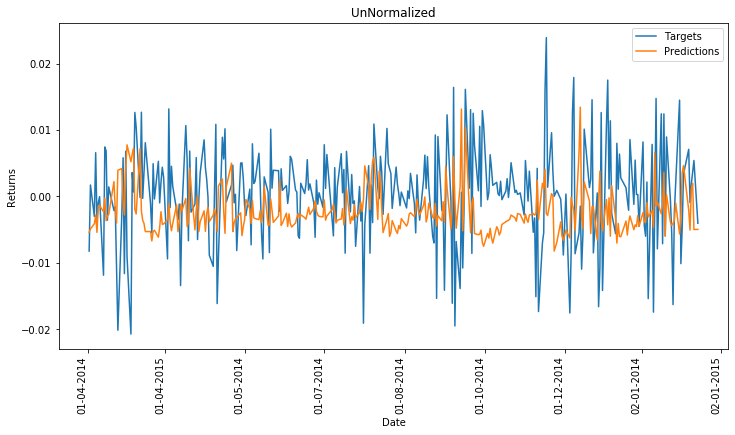

In [9]:
targets = testdf["Target"]*(max_ - min_) + min_

dataDf = pd.DataFrame({'Predictions':predictions, 'Targets':targets})
dataDf.index = testdf.index
dataDf

fig, ax = plt.subplots(figsize = (12,6))
fig = sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

x_dates = dataDf.index.strftime('%d-%m-%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');
ax.set_ylabel('Returns')
ax.set_title("UnNormalized")